In [1]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

import torch

torch.__version__

'1.7.1'

## HyperParameters & Configurations

In [2]:
NORMALIZE_DATA = True
WINDOW_SIZE = 10
Y_DIM = 1
ENCODER_HIDDEN_STATES = 128
DECODER_HIDDEN_STATES = 128
BATCH_SIZE = 256
EPOCHS = 100
VALIDATION_RATIO = 0.2
DROPOUT = 0

## Read NASDAQ 100 raw data

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

raw_data =  pd.read_csv('./nasdaq100_padding.csv').values

scale = StandardScaler().fit(raw_data)

if NORMALIZE_DATA:
    data = scale.transform(raw_data)
else:
    data = raw_data
    
data

array([[-0.82166581, -3.42991957, -1.60918711, ..., -1.86674079,
        -2.14183171, -2.35353513],
       [-0.83220311, -3.40824969, -1.60918711, ..., -1.81032478,
        -2.06400103, -2.35353513],
       [-0.83792335, -3.3938031 , -1.66989855, ..., -1.70183245,
        -2.05801406, -2.34133626],
       ...,
       [ 1.87717227,  1.16289176,  0.06697655, ...,  3.04774477,
        -1.84344086,  1.7048016 ],
       [ 1.88362367,  1.1737267 ,  0.07753506, ...,  3.0501316 ,
        -1.84547643,  1.72163035],
       [ 1.88362367,  1.17131893,  0.0722558 , ...,  3.05447129,
        -1.84248294,  1.72151974]])

In [4]:
from notebook.common import split_data
from torch.utils.data import TensorDataset, DataLoader


def to_tensor(array):
    return torch.from_numpy(array).float()
    

train_X, train_y, val_X, val_y = split_data(data, to_tensor, WINDOW_SIZE, Y_DIM, VALIDATION_RATIO)

print('train_X, train_y :', train_X.shape, train_y.shape)
print('  val_X,   val_y :', val_X.shape, val_y.shape)

train_X, train_y : torch.Size([32439, 10, 82]) torch.Size([32439, 1])
  val_X,   val_y : torch.Size([8103, 10, 82]) torch.Size([8103, 1])


In [5]:
from da_rnn.torch import DARNN, DEVICE
from poutyne import Model, EarlyStopping, ModelCheckpoint

darnn = DARNN(
    n=train_X.shape[2] - 1,
    T=WINDOW_SIZE,
    m=ENCODER_HIDDEN_STATES,
    p=DECODER_HIDDEN_STATES,
    y_dim=Y_DIM,
    dropout=DROPOUT
)

model = Model(
    darnn,
    'adam',
    'mse',
    device=DEVICE
)

save_to = dirname / 'checkpoint_torch.hdf5'

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ModelCheckpoint(
            str(save_to.absolute()),
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            keep_only_last_best=True
        )
    ]
)

Epoch:   1/100 Train steps: 127 Val steps: 32 30.98s loss: 0.146014 val_loss: 0.007219
Epoch 1: val_loss improved from inf to 0.00722, saving file to /Users/kael/Codes/ml/DA-RNN/notebook/checkpoint_torch.hdf5
Epoch:   2/100 Train steps: 127 Val steps: 32 31.84s loss: 0.003750 val_loss: 0.009328
Epoch:   3/100 Train steps: 127 Val steps: 32 31.84s loss: 0.003809 val_loss: 0.006468
Epoch 3: val_loss improved from 0.00722 to 0.00647, saving file to /Users/kael/Codes/ml/DA-RNN/notebook/checkpoint_torch.hdf5
Epoch:   4/100 Train steps: 127 Val steps: 32 31.31s loss: 0.003190 val_loss: 0.005191
Epoch 4: val_loss improved from 0.00647 to 0.00519, saving file to /Users/kael/Codes/ml/DA-RNN/notebook/checkpoint_torch.hdf5
Epoch:   5/100 Train steps: 127 Val steps: 32 29.77s loss: 0.002992 val_loss: 0.007355
Epoch:   6/100 Train steps: 127 Val steps: 32 30.03s loss: 0.002695 val_loss: 0.004275
Epoch 6: val_loss improved from 0.00519 to 0.00427, saving file to /Users/kael/Codes/ml/DA-RNN/notebook/

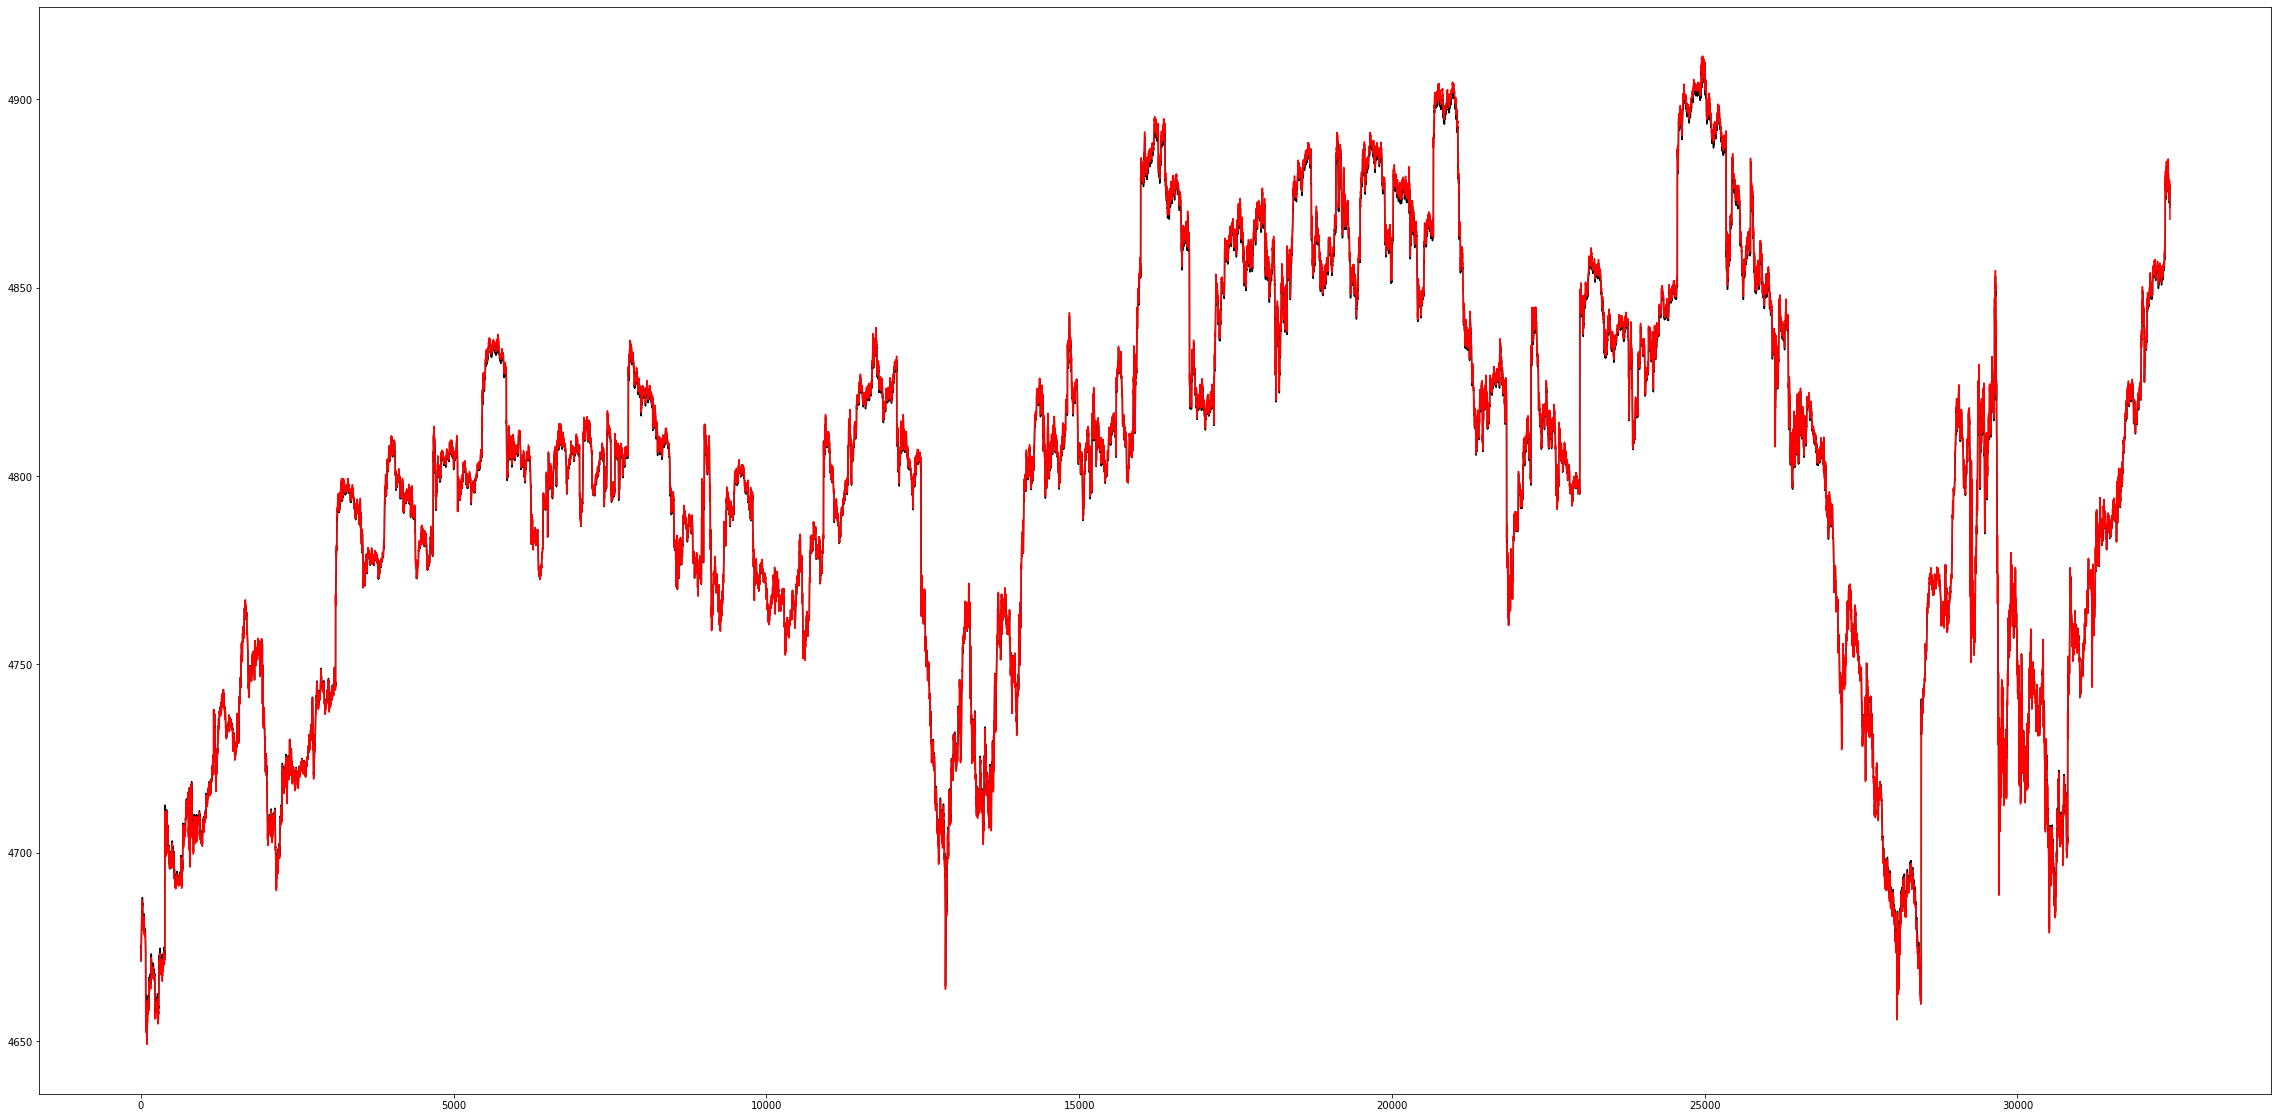

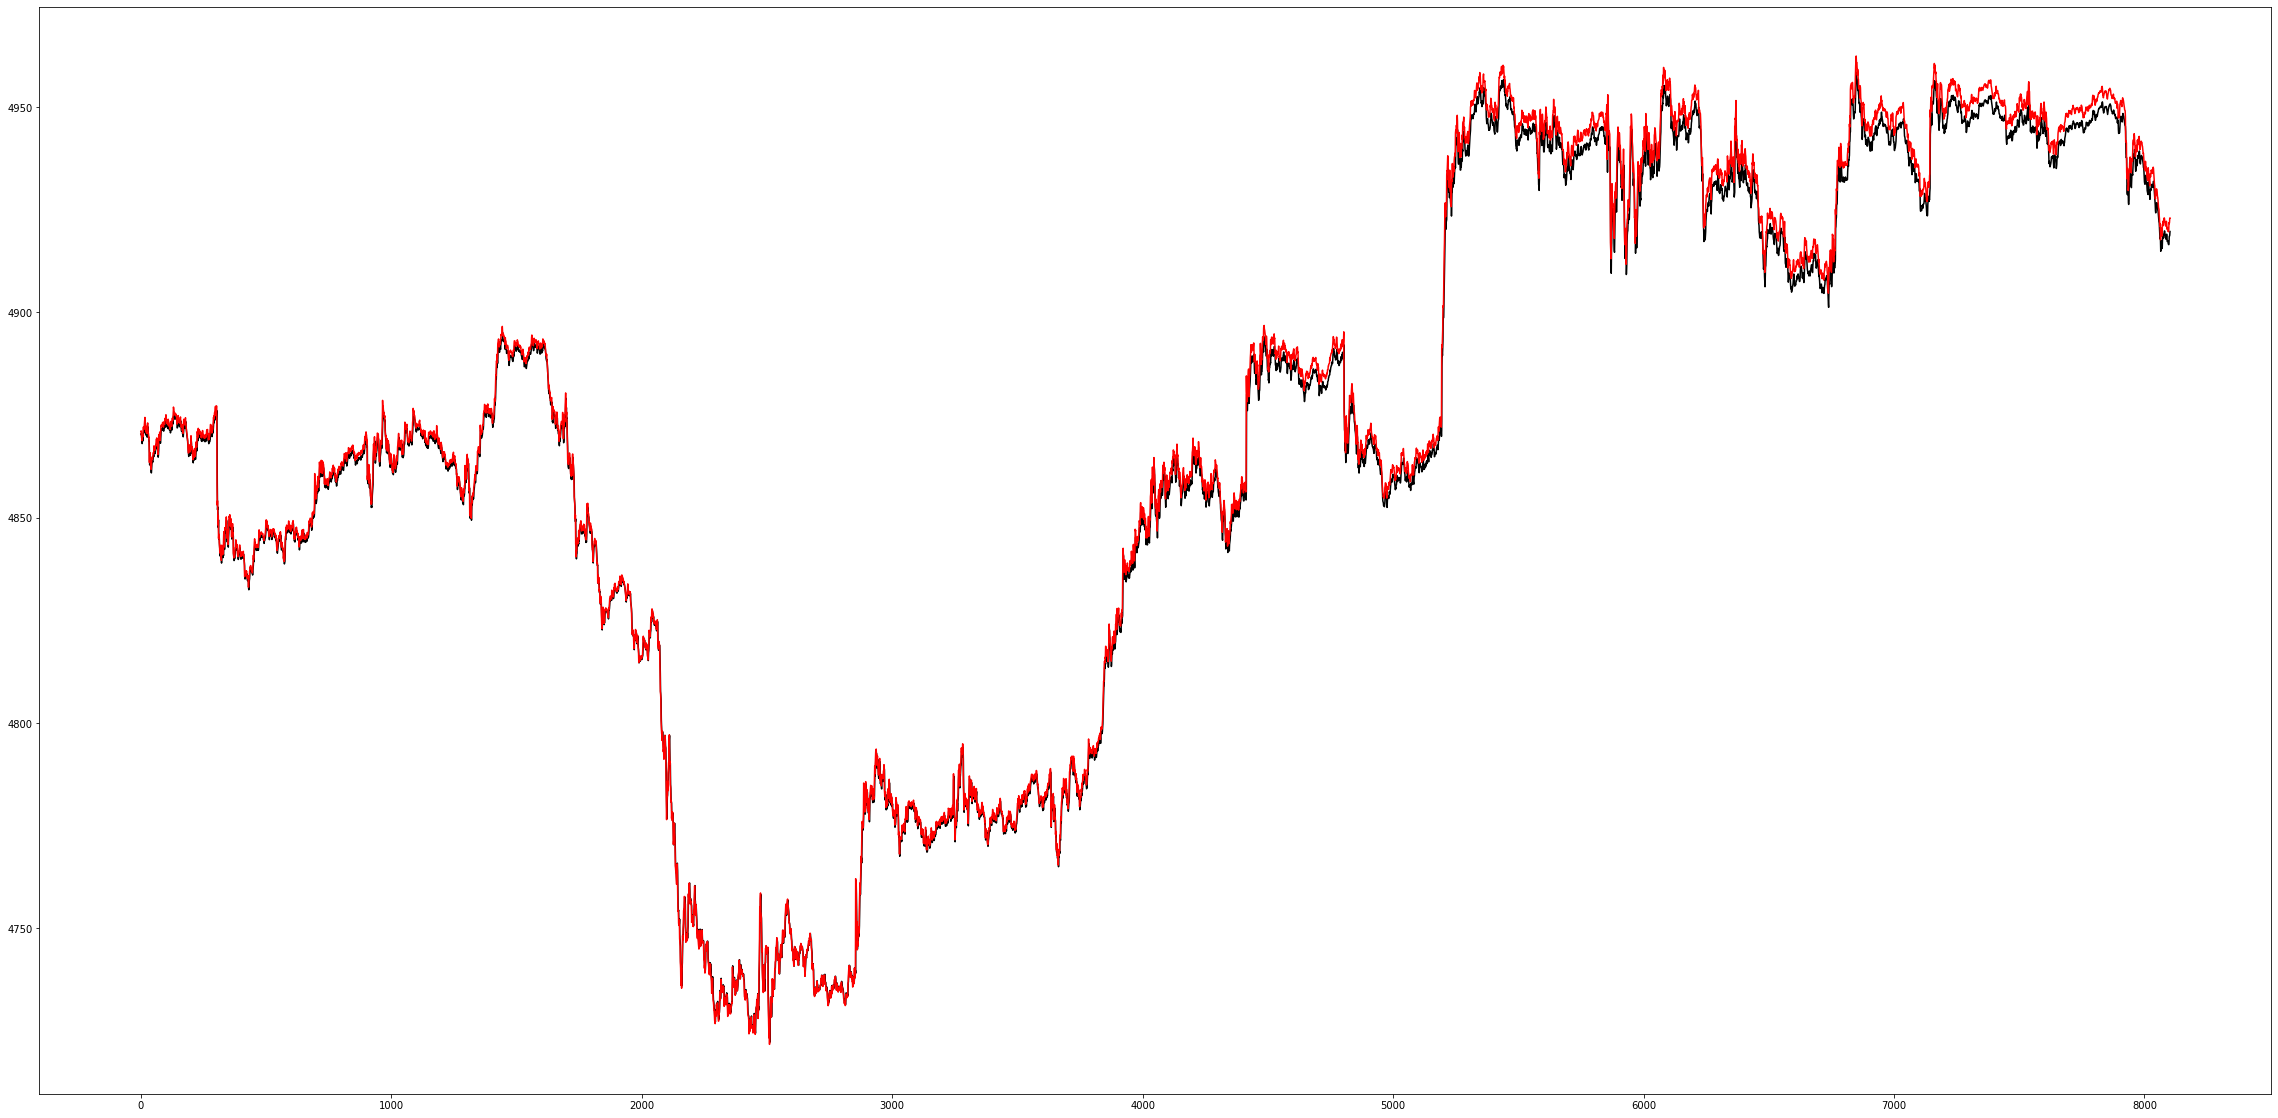

In [6]:
import matplotlib.pyplot as plt


def predict(model, X):
    with torch.no_grad():
        return model(X)
    

train_y_hat = predict(darnn, train_X)
plt.figure(figsize=(40,20))
plt.plot(
    scale.inverse_transform(train_y_hat.cpu().repeat(1,82).numpy())[:,-1],
    'k',
    scale.inverse_transform(train_y.repeat(1,82).numpy())[:,-1],
    'r'
)

val_y_hat = predict(darnn, val_X)
plt.figure(figsize=(40,20))
plt.plot(
    scale.inverse_transform(val_y_hat.cpu().repeat(1,82).numpy())[:,-1],
    'k',
    scale.inverse_transform(val_y.repeat(1,82).numpy())[:,-1],
    'r'
)